[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-4/map-reduce.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239947-lesson-3-map-reduce)

# Map-reduce

## Review

We're building up to a multi-agent research assistant that ties together all of the modules from this course.

To build this multi-agent assistant, we've been introducing a few LangGraph controllability topics.

We just covered parallelization and sub-graphs.

## Goals

Now, we're going to cover [map reduce](https://langchain-ai.github.io/langgraph/how-tos/map-reduce/).

In [1]:
%%capture --no-stderr
%pip install -U langchain_openai langgraph


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

We'll use [LangSmith](https://docs.smith.langchain.com/) for [tracing](https://docs.smith.langchain.com/concepts/tracing).

In [20]:
_set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"

## Problem

Map-reduce operations are essential for efficient task decomposition and parallel processing. 

It has two phases:

(1) `Map` - Break a task into smaller sub-tasks, processing each sub-task in parallel.

(2) `Reduce` - Aggregate the results across all of the completed, parallelized sub-tasks.

Let's design a system that will do two things:

(1) `Map` - Create a set of jokes about a topic.

(2) `Reduce` - Pick the best joke from the list.

We'll use an LLM to do the job generation and selection.

In [4]:
from langchain_openai import ChatOpenAI

# Prompts we will use
subjects_prompt = """Generate a list of of 3 jobs role which are high paying: {topic}."""
job_prompt = """Generate a job description for {subject}"""
best_job_prompt = """Below are a bunch of job descriptions about {topic}. Select the best one! Return the ID of the best one, starting 0 as the ID for the first job description. Job Descriptions: \n\n  {jobs}"""
university_prompt = """Generate a list of of 3 top universities  which got accepted for the job role: {job}."""
# LLM
model = ChatOpenAI(model="gpt-4o", temperature=0) 

## State

### Parallelizing joke generation

First, let's define the entry point of the graph that will:

* Take a user input topic
* Produce a list of joke topics from it
* Send each joke topic to our above joke generation node

Our state has a `jokes` key, which will accumulate jokes from parallelized joke generation

In [14]:
import operator
from typing import Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel
class Universities(BaseModel):
    universities: list[str]

class Subjects(BaseModel):
    subjects: list[str]

class Bestjob(BaseModel):
    id: int
    
class OverallState(TypedDict):
    topic: str
    subjects: list
    jobs: Annotated[list, operator.add]
    best_selected_job: str
    universities: list
     

Generate subjects for jokes.

In [13]:
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}
def generate_university(state: OverallState):
    prompt = university_prompt.format(job=state["best_selected_job"])
    response = model.with_structured_output(Universities).invoke(prompt)
    return {"universities": [response.universities]} 

Here is the magic: we use the [Send](https://langchain-ai.github.io/langgraph/concepts/low_level/#send) to create a joke for each subject.

This is very useful! It can automatically parallelize joke generation for any number of subjects.

* `generate_joke`: the name of the node in the graph
* `{"subject": s`}: the state to send

`Send` allow you to pass any state that you want to `generate_joke`! It does not have to align with `OverallState`.

In this case, `generate_joke` is using its own internal state, and we can populate this via `Send`.

In [15]:
from langgraph.types import Send
def continue_to_jobs(state: OverallState):
    return [Send("generate_job", {"subject": s}) for s in state["subjects"]]

### Joke generation (map)

Now, we just define a node that will create our jokes, `generate_joke`!

We write them back out to `jokes` in `OverallState`! 

This key has a reducer that will combine lists.

In [16]:
class JobState(TypedDict):
    subject: str

class Job(BaseModel):
    job: str

def generate_job(state: JobState):
    prompt = job_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Job).invoke(prompt)
    return {"jobs": [response.job]}

### Best joke selection (reduce)

Now, we add logic to pick the best joke.

In [17]:
def best_job(state: OverallState):
    jobs = "\n\n".join(state["jobs"])
    prompt = best_job_prompt.format(topic=state["topic"], jobs=jobs)
    response = model.with_structured_output(Bestjob).invoke(prompt)
    return {"best_selected_job": state["jobs"][response.id]}

## Compile

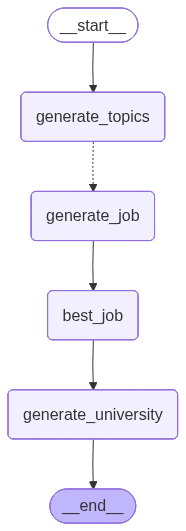

In [18]:
from IPython.display import Image
from langgraph.graph import END, StateGraph, START

# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_job", generate_job)
graph.add_node("best_job", best_job)
graph.add_node("generate_university", generate_university)  # Add this
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jobs, ["generate_job"])
graph.add_edge("generate_job", "best_job")
graph.add_edge("best_job", "generate_university")  # Change this
graph.add_edge("generate_university", END)  # Add this

# Compile the graph
app = graph.compile()
Image(app.get_graph().draw_mermaid_png())

In [19]:
for s in app.stream({"topic": "AI specialist", "jobs": [], "universities": []}):
    print(s)

{'generate_topics': {'subjects': ['**Machine Learning Engineer**: Machine Learning Engineers are responsible for designing and implementing machine learning models and algorithms. They work closely with data scientists to develop scalable solutions that can be integrated into various applications. Their expertise in programming, data analysis, and model optimization makes them highly sought after in industries like tech, finance, and healthcare.\n\n**Data Scientist**: Data Scientists analyze and interpret complex data to help organizations make informed decisions. They use statistical methods, machine learning, and data visualization techniques to uncover insights and trends. Their ability to transform raw data into actionable strategies is crucial for businesses looking to gain a competitive edge.\n\n**AI Research Scientist**: AI Research Scientists focus on advancing the field of artificial intelligence through innovative research and development. They explore new algorithms, models,

## Studio

**⚠️ DISCLAIMER**

Since the filming of these videos, we've updated Studio so that it can be run locally and opened in your browser. This is now the preferred way to run Studio (rather than using the Desktop App as shown in the video). See documentation [here](https://langchain-ai.github.io/langgraph/concepts/langgraph_studio/#local-development-server) on the local development server and [here](https://langchain-ai.github.io/langgraph/how-tos/local-studio/#run-the-development-server). To start the local development server, run the following command in your terminal in the `/studio` directory in this module:

```
langgraph dev
```

You should see the following output:
```
- 🚀 API: http://127.0.0.1:2024
- 🎨 Studio UI: https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024
- 📚 API Docs: http://127.0.0.1:2024/docs
```

Open your browser and navigate to the Studio UI: `https://smith.langchain.com/studio/?baseUrl=http://127.0.0.1:2024`.

Let's load our the above graph in the Studio UI, which uses `module-4/studio/map_reduce.py` set in `module-4/studio/langgraph.json`.